##### Copyright 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Post-training integer quantization with int16 activations

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/lite/performance/post_training_integer_quant_16x8"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/tensorflow/blob/master/tensorflow/lite/g3doc/performance/post_training_integer_quant_16x8.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/tensorflow/blob/master/tensorflow/lite/g3doc/performance/post_training_integer_quant_16x8.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/tensorflow/tensorflow/lite/g3doc/performance/post_training_integer_quant_16x8.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

## Overview

[TensorFlow Lite](https://www.tensorflow.org/lite/) now supports
converting activations to 16-bit integer values and weights to 8-bit integer values during model conversion from TensorFlow to TensorFlow Lite's flat buffer format. We refer to this mode as the "16x8 quantization mode". This mode can improve accuracy of the quantized model significantly, when activations are sensitive to the quantization, while still achieving almost 3-4x reduction in model size. Moreover, this fully quantized model can be consumed by integer-only hardware accelerators. 

Some examples of models that benefit from this mode of the post-training quantization include: 
* super-resolution, 
* audio signal processing such
as noise cancelling and beamforming, 
* image de-noising, 
* HDR reconstruction
from a single image

In this tutorial, you train an MNIST model from scratch, check its accuracy in TensorFlow, and then convert the model into a Tensorflow Lite flatbuffer using this mode. At the end you check the accuracy of the converted model and compare it to the original float32 model. Note that this example demonstrates the usage of this mode and doesn't show benefits over other available quantization techniques in TensorFlow Lite.

## Build an MNIST model

### Setup

In [2]:
import logging
logging.getLogger("tensorflow").setLevel(logging.DEBUG)

import tensorflow as tf
from tensorflow import keras
import numpy as np
import pathlib

2024-07-19 11:32:57.822843: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-19 11:32:57.843687: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-19 11:32:57.850049: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Check that the 16x8 quantization mode is available 

In [3]:
tf.lite.OpsSet.EXPERIMENTAL_TFLITE_BUILTINS_ACTIVATIONS_INT16_WEIGHTS_INT8

<OpsSet.EXPERIMENTAL_TFLITE_BUILTINS_ACTIVATIONS_INT16_WEIGHTS_INT8: 'EXPERIMENTAL_TFLITE_BUILTINS_ACTIVATIONS_INT16_WEIGHTS_INT8'>

### Train and export the model

In [4]:
# Load MNIST dataset
mnist = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Normalize the input image so that each pixel value is between 0 to 1.
train_images = train_images / 255.0
test_images = test_images / 255.0

# Define the model architecture
model = keras.Sequential([
  keras.layers.InputLayer(input_shape=(28, 28)),
  keras.layers.Reshape(target_shape=(28, 28, 1)),
  keras.layers.Conv2D(filters=12, kernel_size=(3, 3), activation=tf.nn.relu),
  keras.layers.MaxPooling2D(pool_size=(2, 2)),
  keras.layers.Flatten(),
  keras.layers.Dense(10)
])

# Train the digit classification model
model.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.fit(
  train_images,
  train_labels,
  epochs=1,
  validation_data=(test_images, test_labels)
)

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
I0000 00:00:1721388780.938871   24036 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


I0000 00:00:1721388780.942464   24036 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1721388780.946054   24036 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1721388780.949871   24036 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1721388780.961762   24036 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

I0000 00:00:1721388782.231904   24036 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1721388782.233758   24036 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1721388782.235733   24036 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1721388782.273081   24036 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

I0000 00:00:1721388783.847182   24201 service.cc:146] XLA service 0x7f53f80085f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1721388783.847231   24201 service.cc:154]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1721388783.847235   24201 service.cc:154]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1721388783.847238   24201 service.cc:154]   StreamExecutor device (2): Tesla T4, Compute Capability 7.5
I0000 00:00:1721388783.847241   24201 service.cc:154]   StreamExecutor device (3): Tesla T4, Compute Capability 7.5


   1/1875 ━━━━━━━━━━━━━━━━━━━━ 56:33 2s/step - accuracy: 0.0625 - loss: 2.3273

  34/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3692 - loss: 2.0933  

  72/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.4933 - loss: 1.8157

 110/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5618 - loss: 1.6029

I0000 00:00:1721388785.025920   24201 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 148/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6063 - loss: 1.4493

 187/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6396 - loss: 1.3303

 226/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6652 - loss: 1.2370

 264/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6850 - loss: 1.1637

 302/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7016 - loss: 1.1021

 340/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7157 - loss: 1.0495

 379/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7281 - loss: 1.0027

 418/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7389 - loss: 0.9621

 457/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7483 - loss: 0.9261

 496/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7567 - loss: 0.8941

 533/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7639 - loss: 0.8671

 570/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7704 - loss: 0.8427

 608/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7763 - loss: 0.8199

 647/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7819 - loss: 0.7986

 685/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7869 - loss: 0.7794

 723/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7915 - loss: 0.7617

 762/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7959 - loss: 0.7449

 801/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8001 - loss: 0.7293

 840/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8039 - loss: 0.7148

 878/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8074 - loss: 0.7017

 917/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8107 - loss: 0.6889

 956/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8139 - loss: 0.6769

 995/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8169 - loss: 0.6655

1032/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8196 - loss: 0.6553

1069/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8222 - loss: 0.6457

1106/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8246 - loss: 0.6364

1143/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8270 - loss: 0.6276

1181/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8293 - loss: 0.6190

1219/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8315 - loss: 0.6107

1256/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8335 - loss: 0.6029

1294/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8356 - loss: 0.5953

1332/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8375 - loss: 0.5880

1370/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8394 - loss: 0.5810

1406/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8411 - loss: 0.5746

1443/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8428 - loss: 0.5683

1480/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8444 - loss: 0.5622

1518/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8460 - loss: 0.5561

1557/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8476 - loss: 0.5501

1594/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8491 - loss: 0.5446

1631/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8505 - loss: 0.5393

1667/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8519 - loss: 0.5343

1704/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8532 - loss: 0.5293

1741/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8545 - loss: 0.5245

1778/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8558 - loss: 0.5198

1815/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8570 - loss: 0.5152

1852/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8582 - loss: 0.5107

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8590 - loss: 0.5079 - val_accuracy: 0.9619 - val_loss: 0.1357


For the example, you trained the model for just a single epoch, so it only trains to ~96% accuracy.

### Convert to a TensorFlow Lite model

Using the TensorFlow Lite [Converter](https://www.tensorflow.org/lite/models/convert), you can now convert the trained model into a TensorFlow Lite model.

Now, convert the model using `TFliteConverter` into default float32 format:

In [5]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmpfs/tmp/tmp3cpnmhnl/assets


INFO:tensorflow:Assets written to: /tmpfs/tmp/tmp3cpnmhnl/assets


Saved artifact at '/tmpfs/tmp/tmp3cpnmhnl'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 28, 28), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  140006282905200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140006282905024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140006283064064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140006283063888: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1721388789.159487   24036 tf_tfl_flatbuffer_helpers.cc:392] Ignored output_format.
W0000 00:00:1721388789.159516   24036 tf_tfl_flatbuffer_helpers.cc:395] Ignored drop_control_dependency.


Write it out to a `.tflite` file:

In [6]:
tflite_models_dir = pathlib.Path("/tmp/mnist_tflite_models/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)

In [7]:
tflite_model_file = tflite_models_dir/"mnist_model.tflite"
tflite_model_file.write_bytes(tflite_model)

84668

To instead quantize the model to 16x8 quantization mode, first set the `optimizations` flag to use default optimizations. Then specify that 16x8 quantization mode is the required supported operation in the  target specification:

In [8]:
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.EXPERIMENTAL_TFLITE_BUILTINS_ACTIVATIONS_INT16_WEIGHTS_INT8]

As in the case of int8 post-training quantization, it is possible to produce a fully integer quantized model by setting converter options `inference_input(output)_type` to tf.int16.

Set the calibration data:

In [9]:
mnist_train, _ = tf.keras.datasets.mnist.load_data()
images = tf.cast(mnist_train[0], tf.float32) / 255.0
mnist_ds = tf.data.Dataset.from_tensor_slices((images)).batch(1)
def representative_data_gen():
  for input_value in mnist_ds.take(100):
    # Model has only one input so each data point has one element.
    yield [input_value]
converter.representative_dataset = representative_data_gen

Finally, convert the model as usual. Note, by default the converted model will still use float input and outputs for invocation convenience.

In [10]:
tflite_16x8_model = converter.convert()
tflite_model_16x8_file = tflite_models_dir/"mnist_model_quant_16x8.tflite"
tflite_model_16x8_file.write_bytes(tflite_16x8_model)

INFO:tensorflow:Assets written to: /tmpfs/tmp/tmp9qbz4sxj/assets


INFO:tensorflow:Assets written to: /tmpfs/tmp/tmp9qbz4sxj/assets


Saved artifact at '/tmpfs/tmp/tmp9qbz4sxj'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 28, 28), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  140006282905200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140006282905024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140006283064064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140006283063888: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1721388790.014921   24036 tf_tfl_flatbuffer_helpers.cc:392] Ignored output_format.
W0000 00:00:1721388790.014945   24036 tf_tfl_flatbuffer_helpers.cc:395] Ignored drop_control_dependency.


25144

Note how the resulting file is approximately `1/3` the size.

In [11]:
!ls -lh {tflite_models_dir}

total 140K
-rw-rw-r-- 1 kbuilder kbuilder 83K Jul 19 11:33 mnist_model.tflite
-rw-rw-r-- 1 kbuilder kbuilder 25K Jul 19 11:31 mnist_model_quant.tflite
-rw-rw-r-- 1 kbuilder kbuilder 25K Jul 19 11:33 mnist_model_quant_16x8.tflite


## Run the TensorFlow Lite models

Run the TensorFlow Lite model using the Python TensorFlow Lite Interpreter.

### Load the model into the interpreters

In [12]:
interpreter = tf.lite.Interpreter(model_path=str(tflite_model_file))
interpreter.allocate_tensors()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [13]:
interpreter_16x8 = tf.lite.Interpreter(model_path=str(tflite_model_16x8_file))
interpreter_16x8.allocate_tensors()

### Test the models on one image

In [14]:
test_image = np.expand_dims(test_images[0], axis=0).astype(np.float32)

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

interpreter.set_tensor(input_index, test_image)
interpreter.invoke()
predictions = interpreter.get_tensor(output_index)

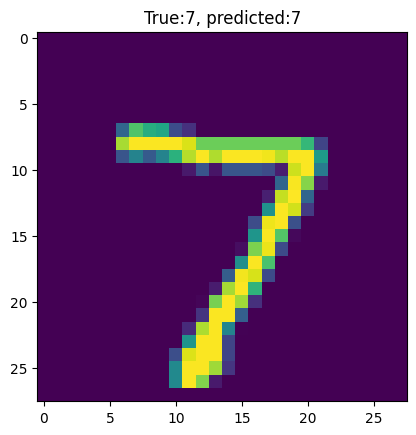

In [15]:
import matplotlib.pylab as plt

plt.imshow(test_images[0])
template = "True:{true}, predicted:{predict}"
_ = plt.title(template.format(true= str(test_labels[0]),
                              predict=str(np.argmax(predictions[0]))))
plt.grid(False)

In [16]:
test_image = np.expand_dims(test_images[0], axis=0).astype(np.float32)

input_index = interpreter_16x8.get_input_details()[0]["index"]
output_index = interpreter_16x8.get_output_details()[0]["index"]

interpreter_16x8.set_tensor(input_index, test_image)
interpreter_16x8.invoke()
predictions = interpreter_16x8.get_tensor(output_index)

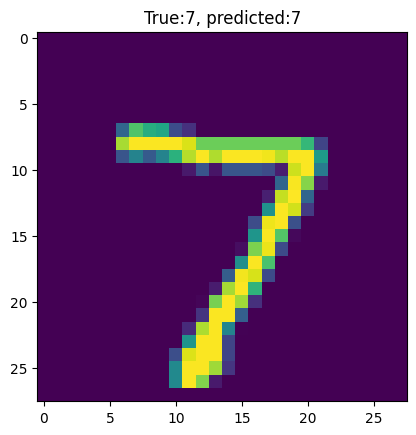

In [17]:
plt.imshow(test_images[0])
template = "True:{true}, predicted:{predict}"
_ = plt.title(template.format(true= str(test_labels[0]),
                              predict=str(np.argmax(predictions[0]))))
plt.grid(False)

### Evaluate the models

In [18]:
# A helper function to evaluate the TF Lite model using "test" dataset.
def evaluate_model(interpreter):
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]

  # Run predictions on every image in the "test" dataset.
  prediction_digits = []
  for test_image in test_images:
    # Pre-processing: add batch dimension and convert to float32 to match with
    # the model's input data format.
    test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
    interpreter.set_tensor(input_index, test_image)

    # Run inference.
    interpreter.invoke()

    # Post-processing: remove batch dimension and find the digit with highest
    # probability.
    output = interpreter.tensor(output_index)
    digit = np.argmax(output()[0])
    prediction_digits.append(digit)

  # Compare prediction results with ground truth labels to calculate accuracy.
  accurate_count = 0
  for index in range(len(prediction_digits)):
    if prediction_digits[index] == test_labels[index]:
      accurate_count += 1
  accuracy = accurate_count * 1.0 / len(prediction_digits)

  return accuracy

In [19]:
print(evaluate_model(interpreter))

0.9619


Repeat the evaluation on the 16x8 quantized model:

In [20]:
# NOTE: This quantization mode is an experimental post-training mode,
# it does not have any optimized kernels implementations or
# specialized machine learning hardware accelerators. Therefore,
# it could be slower than the float interpreter.
print(evaluate_model(interpreter_16x8))

0.9618


In this example, you have quantized a model to 16x8 with no difference in the accuracy, but with the 3x reduced size.
